In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
!ls

cal_bleu_score.ipynb  demo.ipynb     loss.ipynb
checkpoints	      DL_Report.pdf  training.ipynb
data		      DL_Slide.pptx  translate_en_vi_converter


In [3]:
# cd drive/MyDrive/Deep Learning

/content/drive/MyDrive/Deep Learning


In [4]:
! pip3 install -q tensorflow_datasets
! pip3 install -q tensorflow_text

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [5]:
import os
import unicodedata
import regex as re
import numpy as np

import collections
import logging
import pathlib
import re
import string
import sys
import time

import matplotlib.pyplot as plt

import tensorflow_text as tf_text
import tensorflow as tf

import nltk.translate.bleu_score as bleu

In [6]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [7]:
os.listdir('data')

['test.en',
 'test.vi',
 'train.en',
 'validation.vi',
 'train.vi',
 'validation.en']

In [8]:
def create_dataset(src_file, trg_file):
    with open(src_file, 'r', encoding='utf-8') as f:
        list_src = f.readlines()
    
    with open(trg_file, 'r', encoding='utf-8') as f:
        list_trg = f.readlines()
    
    dataset = tf.data.Dataset.from_tensor_slices((list_src, list_trg))
    dataset = dataset.prefetch(0)

    return dataset

In [9]:
# tạo dataset từ các file
train_examples = create_dataset("data/train.en", "data/train.vi")
validation_examples = create_dataset("data/validation.en", "data/validation.vi")
test_examples = create_dataset("data/test.en", "data/test.vi")

In [10]:
model_name = 'translate_en_vi_converter'
tokenizers = tf.saved_model.load(model_name)

In [11]:
for en_examples, vi_examples in train_examples.batch(3).take(1):
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

    print()

    for vi in vi_examples.numpy():
        print(vi.decode('utf-8'))

rachel pike : the science behind a climate headline

in 4 minutes , atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .

i 'd like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .


khoa học đằng sau một tiêu đề về khí hậu

trong 4 phút , chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .

tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .



In [12]:
encoded = tokenizers.vi.tokenize(vi_examples)

for row in encoded.to_list():
  print(row)

[2, 449, 217, 1227, 260, 162, 500, 265, 189, 515, 811, 3]
[2, 172, 23, 690, 15, 791, 302, 324, 217, 515, 1065, 182, 3198, 54, 582, 1991, 241, 1127, 1089, 1354, 189, 165, 1236, 415, 449, 217, 3274, 2851, 1227, 260, 165, 500, 265, 1582, 1086, 189, 454, 295, 515, 811, 15, 268, 179, 1398, 430, 370, 166, 242, 16, 16, 319, 1012, 171, 176, 2200, 1620, 181, 483, 609, 175, 16, 16, 162, 958, 530, 1440, 799, 287, 1121, 1056, 188, 304, 613, 310, 289, 189, 162, 424, 503, 2580, 1402, 17, 3]
[2, 160, 235, 181, 173, 169, 224, 189, 180, 784, 273, 166, 165, 1236, 415, 449, 217, 176, 1142, 285, 183, 231, 173, 1001, 3013, 169, 347, 208, 216, 632, 17, 3]


In [13]:
round_trip = tokenizers.vi.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

khoa học đằng sau một tiêu đề về khí hậu
trong 4 phút , chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình - - hàng ngàn người đã cống hiến cho dự án này - - một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .
tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .


In [14]:
def tokenize_pairs(en, vi):
    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()

    vi = tokenizers.vi.tokenize(vi)
    vi = vi.to_tensor()
    
    return en, vi

In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [16]:
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
validation_batches = make_batches(validation_examples)
test_batches = make_batches(test_examples)

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

  # dùng hàm sin cho vị trí chẵn
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # dùng hàm cos cho vị trí lẻ
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
# hàm tạo mask cho câu
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [20]:
# hàm tạo mask để che đi phần chưa được dịch đến
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
  # tính trọng số attention
  # đầu vào bao gồm q(query), k(key), v(value)
  # tính toán theo công thức
  
  """
  Các tham số
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: (..., seq_len_q, seq_len_k). Mặc định là None.
  """

  # nhân q với k
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # chia cho sqrt(d_k)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # thêm mask nếu có
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # dùng hàm softmax để chuẩn hóa về dạng xác suất
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    # chia d_model thành các head, mỗi head có số chiều là depth
    # chuyển tensor theo shape là (batch_size, num_heads, seq_len, depth)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [23]:
# fully connected neural network
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # embedding đầu vào và thực hiện positional encoding
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [28]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [29]:
num_layers = 4
d_model = 256
dff = 1024
num_heads = 4
dropout_rate = 0.1

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=30000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

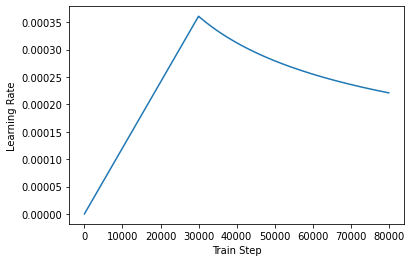

In [32]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(80000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1, reduction='none')

In [34]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  real_ = tf.one_hot(tf.cast(real, tf.int64), tokenizers.vi.get_vocab_size())

  loss_ = loss_object(real_, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.Mean(name='validation_accuracy')

In [36]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.en.get_vocab_size(),
    target_vocab_size=tokenizers.vi.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [37]:
def create_masks(inp, tar):
  # Tạo padding mask cho encoder
  enc_padding_mask = create_padding_mask(inp)

  # Dùng trong tầng attention thứ hai trong decoder
  # Mask này để che đi output của encoder
  dec_padding_mask = create_padding_mask(inp)

  # Tạo mask cho tầng attention thứ nhất của decoder
  # Dùng để padding và che các từ chưa được dịch từ đầu vào của decoder
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [38]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [39]:
EPOCHS = 25

In [40]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1] # đầu vào cho decoder
  tar_real = tar[:, 1:] # đầu ra cho mô hình

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    # tính lỗi
    loss = loss_function(tar_real, predictions)
  
    
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))
  

In [41]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> english, tar -> vietnamese
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
    if batch % 200 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  
  validation_loss.reset_states()
  validation_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(validation_batches):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    val_loss = loss_function(tar_real, predictions)

    validation_loss(val_loss)
    validation_accuracy(accuracy_function(tar_real, predictions))

  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
  

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Validation loss: {validation_loss.result():.4f} Validation accuracy {validation_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.4041 Accuracy 0.0000
Epoch 1 Batch 200 Loss 8.2995 Accuracy 0.0156
Epoch 1 Batch 400 Loss 8.1519 Accuracy 0.0264
Epoch 1 Batch 600 Loss 8.0186 Accuracy 0.0309
Epoch 1 Batch 800 Loss 7.8771 Accuracy 0.0346
Epoch 1 Batch 1000 Loss 7.7215 Accuracy 0.0406
Epoch 1 Batch 1200 Loss 7.5652 Accuracy 0.0474
Epoch 1 Batch 1400 Loss 7.4244 Accuracy 0.0539
Epoch 1 Batch 1600 Loss 7.3062 Accuracy 0.0596
Epoch 1 Batch 1800 Loss 7.2075 Accuracy 0.0653
Epoch 1 Batch 2000 Loss 7.1226 Accuracy 0.0709
Epoch 1 Batch 2200 Loss 7.0454 Accuracy 0.0764
Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1
Epoch 1 Loss 7.0060 Accuracy 0.0794
Validation loss: 6.2116 Validation accuracy 0.1388
Time taken for 1 epoch: 269.47 secs

Epoch 2 Batch 0 Loss 6.3748 Accuracy 0.1323
Epoch 2 Batch 200 Loss 6.1839 Accuracy 0.1422
Epoch 2 Batch 400 Loss 6.1485 Accuracy 0.1459
Epoch 2 Batch 600 Loss 6.1035 Accuracy 0.1501
Epoch 2 Batch 800 Loss 6.0661 Accuracy 0.1538
Epoch 2 Batch 1000 Loss 6.0321 